In [52]:
import xarray as xr
import numpy as np
import pandas as pd
from pylab import *
from datetime import date

from scipy.interpolate import griddata

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import matplotlib.colors

import yaml
import glob

import metpy
import metpy.calc as mpcalc
from metpy.units import units
# from metpy.future import precipitable_water

from tqdm import tqdm_notebook as tqdm
from tqdm import trange

from pandas import DataFrame
from sklearn import linear_model

In [29]:
allyamlfiles = sorted(glob.glob('*.yaml'))
all_sondes = xr.open_dataset('all_sondes.nc')
all_sondes = all_sondes.where(all_sondes.Platform == 'HALO',drop=True)

circle_times = []
flight_date = []

for i in allyamlfiles :
    with open(i) as source:
        flightinfo = yaml.load(source, Loader=yaml.SafeLoader)

    circle_times.append([(c["start"], c["end"]) 
                         for c in flightinfo["segments"] if c["kind"] == "circle"])
    flight_date.append(np.datetime64(date.strftime(flightinfo['date'],'%Y-%m-%d')))

circles = []

for i in range(len(flight_date)) :
    for j in range(len(circle_times[i])) :
        circles.append(all_sondes.sel(launch_time=slice(circle_times[i][j][0] - datetime.timedelta(minutes=2),
                                                        circle_times[i][j][1] + datetime.timedelta(minutes=2))))

In [8]:
all_circles = xr.open_dataset('circle_products.nc')
all_sondes = xr.open_dataset('all_sondes.nc')

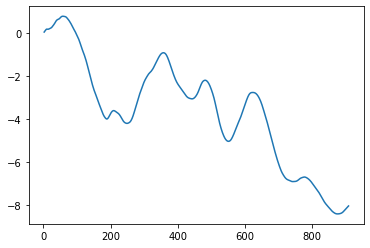

In [53]:
plt.plot(all_circles.sel(circle='0205C6').omega)

In [33]:
circles[i].w_wind#.mean(dim='launch_time')

<xarray.DataArray 'w_wind' (launch_time: 10, alt: 910)>
array([[        nan,         nan, -0.39581711, ..., -1.1497867 ,
        -1.12431057, -1.11134532],
       [        nan, -0.84362294, -0.79976003, ..., -1.4236456 ,
        -1.42060015, -1.41344259],
       [        nan,         nan,  0.31357752, ..., -0.87915933,
        -0.88699151, -0.91172039],
       ...,
       [        nan,         nan, -0.38551369, ..., -1.19195309,
        -1.21795993, -1.23778603],
       [        nan,         nan, -0.94361918, ..., -2.18719668,
        -2.22171496, -2.24136218],
       [        nan, -0.39483201, -0.40301518, ..., -0.83558017,
        -0.8441771 , -0.86169831]])
Coordinates:
  * launch_time  (launch_time) datetime64[ns] 2020-02-02T11:52:31 ... 2020-02-02T12:38:03
  * alt          (alt) int64 0 10 20 30 40 50 ... 9040 9050 9060 9070 9080 9090
Attributes:
    long_name:      vertical component of winds
    units:          m/s
    standard_name:  upward_air_velocity

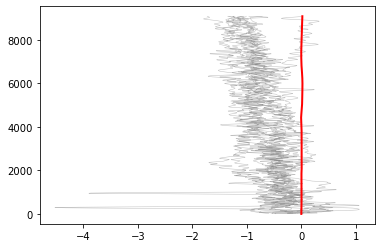

In [42]:
i = 22
for j in circles[i].launch_time :
    plt.plot(circles[i].w_wind.sel(launch_time=j),circles[i].alt,c='grey',alpha=0.5,linewidth=0.5)
    
plt.plot(all_circles.isel(circle=i).w,all_circles.height,c='r',linewidth=2)

In [71]:
pre = xr.open_dataset('pre_eurec4a_soundings_1989_to_2019_v0.1.nc')
rh = mpcalc.relative_humidity_from_dewpoint(pre.temperature.values*units.degC,
                                           pre.dewpoint.values*units.degC).magnitude

pre['rh'] = (['date_and_time','height'],rh*100)
pre['speed'] = (['date_and_time','height'],pre.speed*0.5144)
pre['u_wind'] = (['date_and_time','height'],pre.u_wind*0.5144)
pre['v_wind'] = (['date_and_time','height'],pre.v_wind*0.5144)

eur = xr.open_dataset('all_sondes.nc')

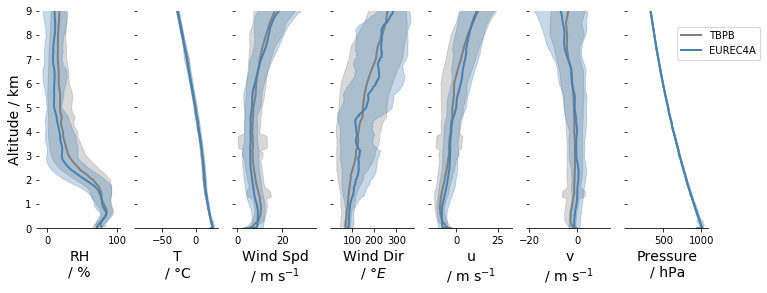

In [90]:
pre_var = ('rh','temperature','speed','direction','u_wind','v_wind','pressure')
eur_var = ('rh','tdry','wspd','wdir','u_wind','v_wind','pres')
xlabels = ('RH\n/ %', 'T\n/ $\degree$C', 'Wind Spd\n/ m s$^{-1}$','Wind Dir\n/ $\degree E$','u\n/ m s$^{-1}$','v\n/ m s$^{-1}$','Pressure\n/ hPa')

f,ax = plt.subplots(1,len(pre_var),sharey=True,figsize=(12,4))

for g,i in enumerate(pre_var) :
    mean = pre[i].mean(dim='date_and_time')
    std = pre[i].std(dim='date_and_time')
    ax[g].plot(mean,
              pre.height/1000,linewidth = 2, color = 'grey',label='TBPB')
    
    ax[g].fill_betweenx(
        pre.height/1000,
        mean - std,
        mean + std, color = 'grey', alpha=0.3)
    
    ax[g].set_xlabel(xlabels[g],fontsize=14)

for g,i in enumerate(eur_var) :
    mean = eur[i].mean(dim='launch_time')
    std = eur[i].std(dim='launch_time')
    ax[g].plot(mean,
              eur.alt/1000,linewidth = 2, color = 'steelblue',label='EUREC4A')
    
    ax[g].fill_betweenx(
        eur.alt/1000,
        mean - std,
        mean + std, color = 'steelblue', alpha=0.3)
    ax[g].set_ylim(0,9)
    
    
    if g == len(eur_var)-1 :
        ax[g].legend(loc=1,bbox_to_anchor=(1.7, 0.95))
        
    [ax[g].spines[m].set_visible(False) for m in ['right','top','left']]
    
    if g == 0 :
        ax[g].set_ylabel('Altitude / km',fontsize=14)
        
plt.savefig('EUREC4A_vs_TBPB_9km.jpg',dpi=300)

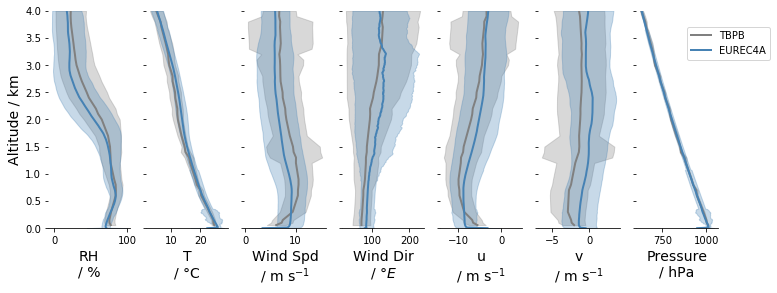

In [74]:
pre_var = ('rh','temperature','speed','direction','u_wind','v_wind','pressure')
eur_var = ('rh','tdry','wspd','wdir','u_wind','v_wind','pres')
xlabels = ('RH\n/ %', 'T\n/ $\degree$C', 'Wind Spd\n/ m s$^{-1}$','Wind Dir\n/ $\degree E$','u\n/ m s$^{-1}$','v\n/ m s$^{-1}$','Pressure\n/ hPa')

f,ax = plt.subplots(1,len(pre_var),sharey=True,figsize=(12,4))

for g,i in enumerate(pre_var) :
    mean = pre[i].sel(height=slice(0,4000)).mean(dim='date_and_time')
    std = pre[i].sel(height=slice(0,4000)).std(dim='date_and_time')
    ax[g].plot(mean,
              pre.sel(height=slice(0,4000)).height/1000,linewidth = 2, color = 'grey',label='TBPB')
    
    ax[g].fill_betweenx(
        pre.sel(height=slice(0,4000)).height/1000,
        mean - std,
        mean + std, color = 'grey', alpha=0.3)
    
    ax[g].set_xlabel(xlabels[g],fontsize=14)

for g,i in enumerate(eur_var) :
    mean = eur[i].sel(alt=slice(0,4000)).mean(dim='launch_time')
    std = eur[i].sel(alt=slice(0,4000)).std(dim='launch_time')
    ax[g].plot(mean,
              eur.sel(alt=slice(0,4000)).alt/1000,linewidth = 2, color = 'steelblue',label='EUREC4A')
    
    ax[g].fill_betweenx(
        eur.sel(alt=slice(0,4000)).alt/1000,
        mean - std,
        mean + std, color = 'steelblue', alpha=0.3)
    ax[g].set_ylim(0,4)
    
    
    if g == len(eur_var)-1 :
        ax[g].legend(loc=1,bbox_to_anchor=(1.7, 0.95))
        
    [ax[g].spines[m].set_visible(False) for m in ['right','top','left']]
    
    if g == 0 :
        ax[g].set_ylabel('Altitude / km',fontsize=14)
        
plt.savefig('EUREC4A_vs_TBPB_4km.jpg',dpi=300)

In [7]:
allyamlfiles = sorted(glob.glob('*.yaml'))
all_sondes = xr.open_dataset('all_sondes.nc')
all_sondes = all_sondes.where(all_sondes.Platform == 'HALO',drop=True)

circle_times = []
flight_date = []

for i in allyamlfiles[0:1] :
    with open(i) as source:
        flightinfo = yaml.load(source, Loader=yaml.SafeLoader)

    circle_times.append([(c["start"], c["end"]) 
                         for c in flightinfo["segments"] if c["kind"] == "circle"])
    flight_date.append(np.datetime64(date.strftime(flightinfo['date'],'%Y-%m-%d')))

circles = []

for i in range(len(flight_date)) :
    for j in range(len(circle_times[i])) :
        circles.append(all_sondes.sel(launch_time=slice(circle_times[i][j][0] - datetime.timedelta(minutes=2),
                                                        circle_times[i][j][1] + datetime.timedelta(minutes=2))))

In [12]:
circles[0].q

<xarray.DataArray 'q' (launch_time: 12, alt: 910)>
array([[       nan,        nan, 0.0134758 , ..., 0.00038424, 0.00038179,
        0.00037906],
       [       nan,        nan, 0.01308129, ..., 0.0003648 , 0.0003625 ,
        0.00035992],
       [       nan,        nan, 0.013104  , ..., 0.00035423, 0.00035293,
        0.00035136],
       ...,
       [       nan, 0.01543274, 0.01536033, ..., 0.00037821, 0.00037876,
        0.00037957],
       [       nan,        nan,        nan, ..., 0.0003922 , 0.00039465,
        0.00039751],
       [       nan,        nan, 0.01414427, ..., 0.00038225, 0.00038167,
        0.00038124]])
Coordinates:
  * launch_time  (launch_time) datetime64[ns] 2020-01-22T15:18:15 ... 2020-01-22T16:12:57
  * alt          (alt) int64 0 10 20 30 40 50 ... 9040 9050 9060 9070 9080 9090

In [245]:
nan_counts = []
launch_times = []

for j in range(len(circles)) :
    for i in range(len(circles[j].launch_time)) :
        nan_counts.append(np.isnan(circles[j].u_wind.isel(launch_time=i)).sum().values)
        launch_times.append(circles[j].launch_time.isel(launch_time=i).values)

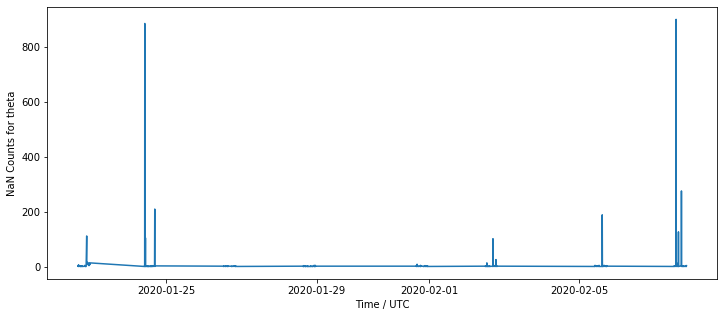

In [246]:
plt.figure(figsize=(12,5))
plt.plot(launch_times,nan_counts)
plt.xlabel('Time / UTC')
plt.ylabel('NaN Counts for theta')
plt.xticks(plt.gca().get_xticks()[1::2])
plt.savefig('NaN Counts for profiles.pdf')
# nan_counts

In [247]:
for i in range(len(circles)) :

        x_coor = circles[i]['lon']*111.320*cos(np.radians(circles[i]['lat']))*1000
        y_coor = circles[i]['lat']*110.54*1000

        # converting from lat, lon to coordinates in metre from (0,0). 

        xc = [None] * len(x_coor.T)
        yc = [None] * len(y_coor.T)

        xc = np.mean(x_coor,axis=0)
        yc = np.mean(y_coor,axis=0)

        delta_x = (x_coor - xc)#*111*1000 # difference of sonde long from mean long
        delta_y = (y_coor - yc)#*111*1000 # difference of sonde lat from mean lat

        u_o = np.mean(circles[i]['u_wind'],axis=0) # mean u velocity
        v_o = np.mean(circles[i]['v_wind'],axis=0) # mean v velocity

        delta_u = circles[i]['u_wind'] - u_o # difference of sonde u from mean u
        delta_v = circles[i]['v_wind'] - v_o # difference of sonde v from mean v

        y_u = delta_u/delta_y # yu (ratio; delta u & delta y: refer notes)
        y_v = delta_v/delta_y # yv (ratio; delta v & delta y: refer notes)

        x = delta_x/delta_y # x (ratio; delta x & delta y: refer notes)

        circles[i]['dx'] = (['launch_time','alt'],delta_x)
        circles[i]['dy'] = (['launch_time','alt'],delta_y)
        circles[i]['qu'] = (['launch_time','alt'],
                            circles[i]['q']*circles[i]['u_wind'])
        circles[i]['qv'] = (['launch_time','alt'],
                            circles[i]['q']*circles[i]['v_wind'])
        circles[i]['Tu'] = (['launch_time','alt'],
                            (circles[i]['tdry']+ 273.15)*circles[i]['u_wind'] )
        circles[i]['Tv'] = (['launch_time','alt'],
                            (circles[i]['tdry']+ 273.15)*circles[i]['v_wind'] )

/Users/geet/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [316]:
m_u = np.full((len(circles),len(circles[0].alt)),np.nan)
m_v = np.full((len(circles),len(circles[0].alt)),np.nan)
c_u = np.full((len(circles),len(circles[0].alt)),np.nan)
c_v = np.full((len(circles),len(circles[0].alt)),np.nan)
m_q = np.full((len(circles),len(circles[0].alt)),np.nan)
c_q = np.full((len(circles),len(circles[0].alt)),np.nan)
m_T = np.full((len(circles),len(circles[0].alt)),np.nan)
c_T = np.full((len(circles),len(circles[0].alt)),np.nan)

m_qu = np.full((len(circles),len(circles[0].alt)),np.nan)
c_qu = np.full((len(circles),len(circles[0].alt)),np.nan)
m_Tu = np.full((len(circles),len(circles[0].alt)),np.nan)
c_Tu = np.full((len(circles),len(circles[0].alt)),np.nan)

m_qv = np.full((len(circles),len(circles[0].alt)),np.nan)
c_qv = np.full((len(circles),len(circles[0].alt)),np.nan)
m_Tv = np.full((len(circles),len(circles[0].alt)),np.nan)
c_Tv = np.full((len(circles),len(circles[0].alt)),np.nan)

D = np.full((len(circles),len(circles[0].alt)),np.nan)
vor = np.full((len(circles),len(circles[0].alt)),np.nan)
den_m = np.full((len(circles)),[None])
mean_den = np.full((len(circles),len(circles[0].alt)),np.nan)
w_vel = np.full((len(circles),len(circles[0].alt)),np.nan)
p_vel = np.full((len(circles),len(circles[0].alt)),np.nan)

Ns = np.full((len(circles),len(circles[0].alt)),np.nan)


for i in tqdm(range(len(circles))) :
# for i in tqdm(range(1)) :

        #     # loop for linear regression at every level
        for k in range(0,len(circles[i].alt)) :

            df = {'dx':circles[i]['dx'].isel(alt=k),
                  'dy':circles[i]['dy'].isel(alt=k)}
            df_q = {'q':circles[i]['q'].isel(alt=k)}

            ddf = DataFrame(df,columns=['dx','dy'])
            ddf_q = DataFrame(df_q,columns=['q'])

            id_ = np.where((isnan(ddf['dx'])==False) & (isnan(ddf_q['q'])==False))[0]
            
            Ns[i][k] = int(len(id_))

            if id_.size >= 6 :
                X = ddf.values[id_]
                Y_u = circles[i]['u_wind'].isel(alt=k).isel(launch_time=id_)
                Y_v = circles[i]['v_wind'].isel(alt=k).isel(launch_time=id_)
                Y_q = circles[i]['q'].isel(alt=k).isel(launch_time=id_)
                Y_T = circles[i]['tdry'].isel(alt=k).isel(launch_time=id_) + 273.15

                Y_qu = Y_u*Y_q
                Y_qv = Y_v*Y_q

                Y_Tu = Y_u*Y_T
                Y_Tv = Y_v*Y_T

                regr_u = linear_model.LinearRegression()
                regr_u.fit(X,Y_u)

                regr_v = linear_model.LinearRegression()
                regr_v.fit(X,Y_v)

                regr_q = linear_model.LinearRegression()
                regr_q.fit(X,Y_q)

                regr_T = linear_model.LinearRegression()
                regr_T.fit(X,Y_T)

                regr_qu = linear_model.LinearRegression()
                regr_qu.fit(X,Y_qu)

                regr_qv = linear_model.LinearRegression()
                regr_qv.fit(X,Y_qv)

                regr_Tu = linear_model.LinearRegression()
                regr_Tu.fit(X,Y_Tu)

                regr_Tv = linear_model.LinearRegression()
                regr_Tv.fit(X,Y_Tv)

        # #         mean_u = regr.intercept_
                m_u[i][k],c_u[i][k]= regr_u.coef_
                m_v[i][k],c_v[i][k]= regr_v.coef_
                m_q[i][k],c_q[i][k]= regr_q.coef_
                m_T[i][k],c_T[i][k]= regr_T.coef_

                m_qu[i][k],c_qu[i][k] = regr_qu.coef_
                m_Tu[i][k],c_Tu[i][k] = regr_Tu.coef_

                m_qv[i][k],c_qv[i][k] = regr_qv.coef_
                m_Tv[i][k],c_Tv[i][k] = regr_Tv.coef_

#         pres[i] = np.full((len(circles[i].alt)),np.nan)
#         D[i] = np.full((len(circles[i].alt)),np.nan)
#         vor[i] = np.full((len(circles[i].alt)),np.nan)

#         pres[i] = circles[i]['pres'].mean(dim='launch_time')
        D[i] = (m_u[i] + c_v[i]) 
        vor[i] = (m_v[i] - c_u[i]) 

        den_m[i] = mpcalc.density(circles[i]['pres'].values*units.hPa,
                         circles[i]['tdry'].values*units.degC, 
                         circles[i]['mr'].values/1000).magnitude
        mean_den[i] = np.nanmean(den_m[i],axis=0) 

        # Calculating the vertical velocity and pressure velocity
        
#         nan_ids = np.isnan(D[i])
        
#         w_vel[i] = np.nan * len(circles[i].alt)
        w_vel[i][0] = 0   
        
#         for m in range(1,len(circles[i].alt)) :
#             if m-1 is in nan_ids :
#                 w_vel[i][m] = np.nansum(D[i][0:m+1]*10)*(-1)
                
#         for i in range(len(D)) :

        nan_ids = np.where(np.isnan(D[i]) == True)[0]

        w_vel[i][0] = 0
        last = 0

        for m in range(1,len(circles[i].alt)) :

            if m in nan_ids :
                w_vel[i][m] = np.nan
            else :
                w_vel[i][m] = w_vel[i][last] + D[i][m]*10*(m-last)
                last = m

#         p_vel[i] = np.full_like(D[i],np.nan) # Pressure velocity in hPa/h

        for n in range(1,910) :

            p_vel[i][n] = -mean_den[i][n]*9.81*w_vel[i][n]*60*60/100                   

/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice
/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice
/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice
/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice
/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice
/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice
/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice
/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice
/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: Mea

/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: Mean of empty slice


In [308]:
# for i in range(len(D)) :

#     nan_ids = np.where(np.isnan(D[i]) == True)[0]

#     w_vel[i][0] = 0
#     last = 0

#     for m in range(1,len(circles[i].alt)) :

#         if m in nan_ids :
#             w_vel[i][m] = np.nan
#         #     counter.append(m)
#         else :
#             w_vel[i][m] = w_vel[i][last] + D[i][m]*10*(m-last)
#             last = m

In [301]:
last

909

(0, 200)

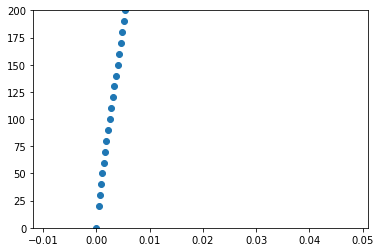

In [309]:
plt.scatter(w_vel[2],circles[0].alt)
plt.ylim(0,200)

In [263]:
m = 4
# np.nansum(D[i][0:m+1]*10)
D[i][0:m+1]

array([            nan,  2.00043443e-06, -4.00589227e-08,  9.37101998e-07,
        1.25516479e-06])

/Users/geet/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/geet/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


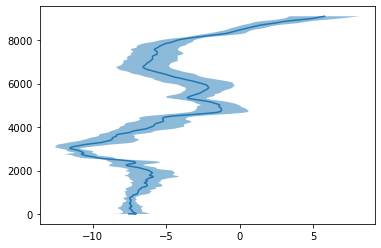

In [226]:
m = circles[30].u_wind.mean(dim='launch_time')
std = circles[30].u_wind.std(dim='launch_time')

plt.plot(m,circles[30].alt)
plt.fill_betweenx(circles[30].alt,
                 m-std,
                 m+std,alpha=0.5)

/Users/geet/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/geet/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


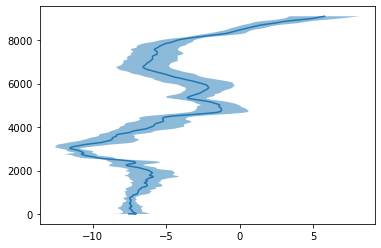

In [103]:
m = circles[30].u_wind.mean(dim='launch_time')
std = circles[30].u_wind.std(dim='launch_time')

plt.plot(m,circles[30].alt)
plt.fill_betweenx(circles[30].alt,
                 m-std,
                 m+std,alpha=0.5)

In [328]:
u = [None] * len(circles)
v = [None] * len(circles)
pres = [None] * len(circles)

for i in range(len(circles)) :
    u[i] = circles[i].u_wind.mean(dim='launch_time').values
    v[i] = circles[i].v_wind.mean(dim='launch_time').values
    pres[i] = circles[i].pres.mean(dim='launch_time').values

/Users/geet/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [2]:
circles[0]

NameError: name 'circles' is not defined

In [329]:
circle = []

for i in flight_date:
    for j in range(1,7) :
        circle.append((f'{i.astype(object).month:02d}{i.astype(object).day:02d}C{j}'))

ds = xr.Dataset({'dudx'     : (['circle','height'],m_u),#{'ad':'dfw','qd':'df'}),
                 'dudy'     : (['circle','height'],c_u),
                 'dvdx'     : (['circle','height'],m_v),
                 'dvdy'     : (['circle','height'],c_v),
                 
                 'dTdx'     : (['circle','height'],m_T),
                 'dTdy'     : (['circle','height'],c_T),
                 'dqdx'     : (['circle','height'],m_q),
                 'dqdy'     : (['circle','height'],c_q),
                 
                 'dqudx'     : (['circle','height'],m_qu),
                 'dqudy'     : (['circle','height'],c_qu),
                 'dqvdx'     : (['circle','height'],m_qv),
                 'dqvdy'     : (['circle','height'],c_qv),
                 
                 'dTudx'     : (['circle','height'],m_Tu),
                 'dTudy'     : (['circle','height'],c_Tu),
                 'dTvdx'     : (['circle','height'],m_Tv),
                 'dTvdy'     : (['circle','height'],c_Tv),
                
                 'pressure'  : (['circle','height'],pres),
                 'divergence': (['circle','height'],D),
                 'vorticity' : (['circle','height'],vor),
                 
                 'u'         : (['circle','height'],u),
                 'v'         : (['circle','height'],v),
                 'w'         : (['circle','height'],w_vel),
                 'omega'     : (['circle','height'],p_vel),
                 
                 'density'   : (['circle','height'],mean_den),
                 'regressed_sondes' : (['circle','height'],Ns)
                 },
                 coords={'height': circles[0].alt.values,
                        'circle': circle},
                 attrs={'Author':'Geet George (MPI-M, Hamburg); geet.george@mpimet.mpg.de',
                       'Instrument':'Vaisala RD94 (AVAPS receiver aboard HALO)',
                       'Data Processing':'AvapsEditorVersion "BatchAspen V3.4.3"',
                       'Campaign':'EUREC4A (Jan-Feb,2020)',
                       'Reference Study': 'Bony, S. & Stevens, B., 2019, “Measuring Area-Averaged Vertical Motions with Dropsondes.” Journal of the Atmospheric Sciences 76 (3): 767–83',
                       'Creation Time' : str(datetime.datetime.utcnow()) + ' UTC'})

file_name = 'circle_products'
# file_name = str(datetime.datetime.utcnow().date()) + '_' + str(datetime.datetime.utcnow().hour)
# file_name = str(circle['launch_time'].mean().values)[0:13]
ds.to_netcdf(file_name + '.nc')

In [205]:
ds

<xarray.Dataset>
Dimensions:           (circle: 36, height: 910)
Coordinates:
  * height            (height) int64 0 10 20 30 40 ... 9050 9060 9070 9080 9090
  * circle            (circle) <U6 '0122C1' '0122C2' ... '0202C5' '0202C6'
Data variables:
    dudx              (circle, height) float64 nan 6.258e-06 ... -7e-06
    dudy              (circle, height) float64 nan -1.015e-05 ... -1.15e-05
    dvdx              (circle, height) float64 nan -3.193e-05 ... -9.028e-06
    dvdy              (circle, height) float64 nan -5.23e-05 ... 2.565e-05
    dTdx              (circle, height) float64 nan 4.555e-06 ... -2.01e-06
    dTdy              (circle, height) float64 nan 1.279e-06 ... -6.601e-06
    dqdx              (circle, height) float64 nan -8.319e-09 ... -2.049e-10
    dqdy              (circle, height) float64 nan 1.598e-09 ... -3.657e-10
    dqudx             (circle, height) float64 nan 1.617e-07 ... -4.042e-09
    dqudy             (circle, height) float64 nan -1.724e-07 ... -6.556e-09
    dqvdx             (circle, height) float64 nan -4.464e-07 ... 7.899e-10
    dqvdy             (circle, height) float64 nan -7.928e-07 ... 5.387e-09
    dTudx             (circle, height) float64 nan 0.00183 ... -0.001775
    dTudy             (circle, height) float64 nan -0.003037 ... -0.002957
    dTvdx             (circle, height) float64 nan -0.009544 ... -0.00223
    dTvdy             (circle, height) float64 nan -0.0156 ... 0.006612 0.006429
    divergence        (circle, height) float64 nan -4.604e-05 ... 1.865e-05
    vorticity         (circle, height) float64 nan -2.178e-05 ... 2.476e-06
    w                 (circle, height) float64 0.0 0.0004604 ... -0.04834
    omega             (circle, height) float64 nan -0.1903 ... 7.802 7.824
    density           (circle, height) float64 nan 1.17 1.169 ... 0.4588 0.4583
    regressed_sondes  (circle, height) float64 0.0 3.0 9.0 ... 11.0 11.0 11.0
Attributes:
    Author:           Geet George (MPI-M, Hamburg); geet.george@mpimet.mpg.de
    Instrument:       Vaisala RD94 (AVAPS receiver aboard HALO)
    Data Processing:  AvapsEditorVersion "BatchAspen V3.4.3"
    Campaign:         EUREC4A (Jan-Feb,2020)
    Reference Study:  Bony, S. & Stevens, B., 2019, “Measuring Area-Averaged ...
    Creation Time:    2020-04-07 12:48:05.082582 UTC

In [248]:
f = plt.figure(figsize=(10,10))

for i in range(6,12) :
    p = plt.plot(ds.isel(circle=i).omega,ds.height,label=i)
    plt.plot(ds.isel(circle=i).regressed_sondes,ds.height,linestyle='--',c=p[0].get_color())
#     plt.ylim(0,200)
    plt.legend()

ValueError: dimensions {'circle'} do not exist

<Figure size 720x720 with 0 Axes>

In [216]:
p[0].get_color()

'#1f77b4'

In [93]:
# for i in range(len(circles)) :

#         x_coor = circles[i]['lon']*111.320*cos(np.radians(circles[i]['lat']))*1000
#         y_coor = circles[i]['lat']*110.54*1000

#         # converting from lat, lon to coordinates in metre from (0,0). 

#         xc = [None] * len(x_coor.T)
#         yc = [None] * len(y_coor.T)

#         xc = np.mean(x_coor,axis=0)
#         yc = np.mean(y_coor,axis=0)

#         delta_x = (x_coor - xc)#*111*1000 # difference of sonde long from mean long
#         delta_y = (y_coor - yc)#*111*1000 # difference of sonde lat from mean lat

#         u_o = np.mean(circles[i]['u_wind'],axis=0) # mean u velocity
#         v_o = np.mean(circles[i]['v_wind'],axis=0) # mean v velocity

#         delta_u = circles[i]['u_wind'] - u_o # difference of sonde u from mean u
#         delta_v = circles[i]['v_wind'] - v_o # difference of sonde v from mean v

#         y_u = delta_u/delta_y # yu (ratio; delta u & delta y: refer notes)
#         y_v = delta_v/delta_y # yv (ratio; delta v & delta y: refer notes)

#         x = delta_x/delta_y # x (ratio; delta x & delta y: refer notes)

#         circles[i]['dx'] = (['launch_time','alt'],delta_x)
#         circles[i]['dy'] = (['launch_time','alt'],delta_y)
#         circles[i]['qu'] = (['launch_time','alt'],
#                             circles[i]['q']*circles[i]['u_wind'])
#         circles[i]['qv'] = (['launch_time','alt'],
#                             circles[i]['q']*circles[i]['v_wind'])
#         circles[i]['Tu'] = (['launch_time','alt'],
#                             (circles[i]['tdry']+ 273.15)*circles[i]['u_wind'] )
#         circles[i]['Tv'] = (['launch_time','alt'],
#                             (circles[i]['tdry']+ 273.15)*circles[i]['v_wind'] )
        
# m_u = np.full((len(circles),len(circles[0].alt)),np.nan)
# m_v = np.full((len(circles),len(circles[0].alt)),np.nan)
# c_u = np.full((len(circles),len(circles[0].alt)),np.nan)
# c_v = np.full((len(circles),len(circles[0].alt)),np.nan)
# m_q = np.full((len(circles),len(circles[0].alt)),np.nan)
# c_q = np.full((len(circles),len(circles[0].alt)),np.nan)
# m_T = np.full((len(circles),len(circles[0].alt)),np.nan)
# c_T = np.full((len(circles),len(circles[0].alt)),np.nan)

# m_qu = np.full((len(circles),len(circles[0].alt)),np.nan)
# c_qu = np.full((len(circles),len(circles[0].alt)),np.nan)
# m_Tu = np.full((len(circles),len(circles[0].alt)),np.nan)
# c_Tu = np.full((len(circles),len(circles[0].alt)),np.nan)

# m_qv = np.full((len(circles),len(circles[0].alt)),np.nan)
# c_qv = np.full((len(circles),len(circles[0].alt)),np.nan)
# m_Tv = np.full((len(circles),len(circles[0].alt)),np.nan)
# c_Tv = np.full((len(circles),len(circles[0].alt)),np.nan)

# D = np.full((len(circles),len(circles[0].alt)),np.nan)
# vor = np.full((len(circles),len(circles[0].alt)),np.nan)
# den_m = np.full((len(circles)),[None])
# mean_den = np.full((len(circles),len(circles[0].alt)),np.nan)
# w_vel = np.full((len(circles),len(circles[0].alt)),np.nan)
# p_vel = np.full((len(circles),len(circles[0].alt)),np.nan)

# # for i in trange(len(circles)) :
# for i in trange(4) :

# #     for j in range(len(circle_times[i])) :

# #         m_u[i] = np.full((len(circles[i].alt)),np.nan)
# #         m_v[i] = np.full((len(circles[i].alt)),np.nan)
# #         c_u[i] = np.full((len(circles[i].alt)),np.nan)
# #         c_v[i] = np.full((len(circles[i].alt)),np.nan)
# #         m_q[i] = np.full((len(circles[i].alt)),np.nan)
# #         c_q[i] = np.full((len(circles[i].alt)),np.nan)
# #         m_T[i] = np.full((len(circles[i].alt)),np.nan)
# #         c_T[i] = np.full((len(circles[i].alt)),np.nan)

# #         m_qu[i] = np.full((len(circles[i].alt)),np.nan)
# #         c_qu[i] = np.full((len(circles[i].alt)),np.nan)
# #         m_Tu[i] = np.full((len(circles[i].alt)),np.nan)
# #         c_Tu[i] = np.full((len(circles[i].alt)),np.nan)

# #         m_qv[i] = np.full((len(circles[i].alt)),np.nan)
# #         c_qv[i] = np.full((len(circles[i].alt)),np.nan)
# #         m_Tv[i] = np.full((len(circles[i].alt)),np.nan)
# #         c_Tv[i] = np.full((len(circles[i].alt)),np.nan)

#         #     # loop for linear regression at every level
#         for k in range(0,len(circles[i].alt)) :

#             df = {'dx':delta_x.isel(alt=k),
#                  'dy':delta_y.isel(alt=k)}
#             df_q = {'q':circles[i]['q'].isel(alt=k)}

#             ddf = DataFrame(df,columns=['dx','dy'])
#             ddf_q = DataFrame(df_q,columns=['q'])

#             id = np.where((isnan(ddf['dx'])==False) & (isnan(ddf_q['q'])==False))[0]

#             if id.size != 0 :
#                 X = ddf.values[id]
#                 Y_u = circles[i]['u_wind'].isel(alt=k).isel(launch_time=id)
#                 Y_v = circles[i]['v_wind'].isel(alt=k).isel(launch_time=id)
#                 Y_q = circles[i]['q'].isel(alt=k).isel(launch_time=id)
#                 Y_T = circles[i]['tdry'].isel(alt=k).isel(launch_time=id) + 273.15

#                 Y_qu = Y_u*Y_q
#                 Y_qv = Y_v*Y_q

#                 Y_Tu = Y_u*Y_T
#                 Y_Tv = Y_v*Y_T

#                 regr_u = linear_model.LinearRegression()
#                 regr_u.fit(X,Y_u)

#                 regr_v = linear_model.LinearRegression()
#                 regr_v.fit(X,Y_v)

#                 regr_q = linear_model.LinearRegression()
#                 regr_q.fit(X,Y_q)

#                 regr_T = linear_model.LinearRegression()
#                 regr_T.fit(X,Y_T)

#                 regr_qu = linear_model.LinearRegression()
#                 regr_qu.fit(X,Y_qu)

#                 regr_qv = linear_model.LinearRegression()
#                 regr_qv.fit(X,Y_qv)

#                 regr_Tu = linear_model.LinearRegression()
#                 regr_Tu.fit(X,Y_Tu)

#                 regr_Tv = linear_model.LinearRegression()
#                 regr_Tv.fit(X,Y_Tv)

#         # #         mean_u = regr.intercept_
#                 m_u[i][k],c_u[i][k]= regr_u.coef_
#                 m_v[i][k],c_v[i][k]= regr_v.coef_
#                 m_q[i][k],c_q[i][k]= regr_q.coef_
#                 m_T[i][k],c_T[i][k]= regr_T.coef_

#                 m_qu[i][k],c_qu[i][k] = regr_qu.coef_
#                 m_Tu[i][k],c_Tu[i][k] = regr_Tu.coef_

#                 m_qv[i][k],c_qv[i][k] = regr_qv.coef_
#                 m_Tv[i][k],c_Tv[i][k] = regr_Tv.coef_

# #         pres[i] = np.full((len(circles[i].alt)),np.nan)
# #         D[i] = np.full((len(circles[i].alt)),np.nan)
# #         vor[i] = np.full((len(circles[i].alt)),np.nan)

# #         pres[i] = circles[i]['pres'].mean(dim='launch_time')
#         D[i] = (m_u[i] + c_v[i]) 
#         vor[i] = (m_v[i] - c_u[i]) 

#         den_m[i] = mpcalc.density(circles[i]['pres'].values*units.hPa,
#                          circles[i]['tdry'].values*units.degC, 
#                          circles[i]['mr'].values/1000).magnitude
#         mean_den[i] = np.nanmean(den_m[i],axis=0) 

#         # Calculating the vertical velocity and pressure velocity

# #         w_vel[i] = np.nan * len(circles[i].alt)
#         w_vel[i][0] = 0   

#         for m in range(1,len(circles[i].alt)) :
#             w_vel[i][m] = np.nansum(D[i][0:m+1]*10)*(-1)

# #         p_vel[i] = np.full_like(D[i],np.nan) # Pressure velocity in hPa/h

#         for n in range(1,910) :

#             p_vel[i][n] = -mean_den[i][n]*9.81*w_vel[i][n]*60*60/100                   

'2020-03-31 18:05:08.760670'

In [1052]:
# Pressure Gradient

upto = 200

lat_points = np.full(size(circles),[None])
lon_points = np.full(size(circles),[None])
p_values = np.full(size(circles),[None])
grid_x = np.full(size(circles),[None])
grid_y = np.full(size(circles),[None])
grid = np.full(size(circles),[None])

mean_time = np.full(size(circles),[None])
da = []

g = 0
for i in range(len(circles)) :
    for j in range(len(circle_times[i])) :

        lat_points[g] = circles[i,j].sel(alt=slice(0,upto)).lat.mean(dim='alt').values
        lon_points[g] = circles[i,j].sel(alt=slice(0,upto)).lon.mean(dim='alt').values + 360
        l_points = list(set(zip(lon_points[g],lat_points[g])))
        p_values[g] = circles[i,j].sel(alt=slice(0,upto)).pres.mean(dim='alt').values
        mean_time[g] = circles[i,j].launch_time.mean().values

        grid_x[g], grid_y[g] = np.mgrid[floor(np.min(lon_points[g])):ceil(np.max(lon_points[g])):0.2, 
                          floor(np.min(lat_points[g])):ceil(np.max(lat_points[g])):0.2]

        grid[g] = griddata(l_points,p_values[g], (grid_x[g],grid_y[g]), method = 'linear')
        
        try :
            da.append(xr.DataArray(grid[g],
                                coords={'lon':(grid_x[g][:,0]),
                                        'lat':(grid_y[g][0]),
                                        'circle':(circles[i,j].launch_time.mean().values)},
                                dims={'lon','lat'}))
        except Exception :
            print(i,j)
#         else :
#             mean_time.append(circles[i,j].launch_time.mean().values)
        
        g+=1

3 1
3 2
3 4


In [1000]:
ds1 = xr.concat(da[:],dim='circle')
ds1.to_netcdf('spatially_gridded_pressure.nc')

In [1067]:
# ds = xr.Dataset({'lat':(['circle','sonde_no'],lat_points),
#                  'lon':(['circle','sonde_no'],lon_points),
#                  'pressure':(['circle','sonde_no'],p_values)},
#                   coords={'circle':(mean_time)})
# ds.to_netcdf('a.nc')

<xarray.DataArray ()>
array(<built-in method values of dict object at 0x1479c6280>, dtype=object)

In [1]:
# ds1 = xr.Dataset({'pressure':(['circle','lon','lat'],grid)},
#                 coords={'circle':(mean_time),
#                         'lon':(grid_x),
#                         'lat':(grid_y)})

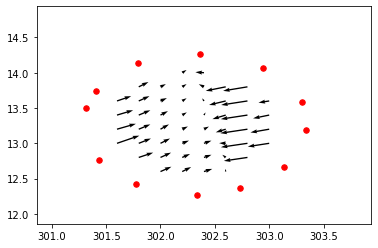

In [668]:
u = np.gradient(grid)[0]
v = np.gradient(grid)[1]

plt.quiver(grid_x,grid_y,u,v)
plt.scatter(lon_points,lat_points,s=30,c='r')

/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Attempting to set identical left == right == 302.83717976659426 results in singular transformations; automatically expanding.
  """
/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Attempting to set identical bottom == top == 12.408204334285857 results in singular transformations; automatically expanding.
  """


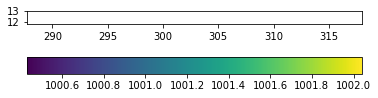

In [911]:
n = 10
plt.imshow(grid[n],interpolation='none', extent=[np.min(lon_points[n]),
                                                 np.max(lon_points[n]),
                                                 np.min(lat_points[n]),
                                                 np.max(lat_points[n])])
plt.colorbar(orientation='horizontal')

In [848]:
shape(grid[0])

(15, 15)

In [695]:
ncds = all_sondes.sel(launch_time='2020-01-24')
ncds = ncds.where(ncds.Platform == 'HALO',drop=True)
ncds = ncds.where(ncds.reference_time != np.datetime64('2020-01-24T00:00:00.000000000'),
                  drop=True).isel(launch_time=slice(0,72))
ncds

<xarray.Dataset>
Dimensions:         (alt: 910, launch_time: 72)
Coordinates:
  * launch_time     (launch_time) datetime64[ns] 2020-01-24T09:50:07 ... 2020-01-24T16:45:06
  * alt             (alt) int64 0 10 20 30 40 50 ... 9050 9060 9070 9080 9090
Data variables:
    trajectory      (launch_time) object b'' b'' b'' b'' b'' ... b'' b'' b'' b''
    pres            (launch_time, alt) float64 nan 1.011e+03 ... 327.3 326.8
    tdry            (launch_time, alt) float64 nan 25.75 25.64 ... -26.4 -26.49
    dp              (launch_time, alt) float64 nan 20.96 20.92 ... -50.84 -50.82
    rh              (launch_time, alt) float64 nan 74.33 74.6 ... 8.247 8.329
    u_wind          (launch_time, alt) float64 nan -5.037 -4.809 ... 16.76 16.71
    v_wind          (launch_time, alt) float64 nan 2.791 2.361 ... -12.27 -12.38
    w_wind          (launch_time, alt) float64 nan -0.1875 ... -1.324 -1.296
    wspd            (launch_time, alt) float64 nan 5.759 5.359 ... 20.77 20.8
    wdir            (launch_time, alt) float64 nan 119.0 116.1 ... 306.2 306.5
    dz              (launch_time, alt) float64 nan -10.03 ... -17.05 -17.03
    mr              (launch_time, alt) float64 nan 15.67 15.64 ... 0.1113 0.1117
    vt              (launch_time, alt) float64 nan 301.8 301.7 ... 246.8 246.7
    theta           (launch_time, alt) float64 nan 298.0 298.0 ... 339.4 339.4
    theta_e         (launch_time, alt) float64 nan 343.6 343.5 ... 339.9 339.9
    theta_v         (launch_time, alt) float64 nan 300.8 300.8 ... 339.4 339.4
    lat             (launch_time, alt) float64 nan 14.13 14.13 ... 14.27 14.27
    lon             (launch_time, alt) float64 nan -58.19 ... -57.91 -57.91
    gpsalt          (launch_time, alt) float64 nan 0.1217 ... 9.117e+03
    reference_time  (launch_time) datetime64[ns] 2020-01-24T09:50:07 ... 2020-01-24T16:45:07
    reference_pres  (launch_time) float32 284.85 284.9 284.8 ... 284.25 284.22
    reference_tdry  (launch_time) float32 -36.1 -36.3 -36.0 ... -35.9 -35.9
    reference_rh    (launch_time) float32 nan nan nan nan ... nan nan nan nan
    reference_wspd  (launch_time) float32 nan nan nan nan ... nan nan nan nan
    reference_wdir  (launch_time) float32 nan nan nan nan ... nan nan nan nan
    reference_lat   (launch_time) float32 14.161172 14.297126 ... 14.278829
    reference_lon   (launch_time) float32 -58.239487 -57.64421 ... -57.92462
    reference_alt   (launch_time) float32 10056.591 10053.458 ... 10081.847
    T_interp        (launch_time, alt) float64 nan 25.75 25.64 ... -26.4 -26.49
    T               (launch_time, alt) float64 nan 25.76 25.66 ... -26.46 -26.55
    rh_interp       (launch_time, alt) float64 nan 74.47 74.74 ... 8.951 9.037
    q               (launch_time, alt) float64 nan 0.01543 ... 0.0001117
    qu              (launch_time, alt) float64 nan -0.07771 ... 0.001866
    qv              (launch_time, alt) float64 nan 0.04306 ... -0.001383
    Tu              (launch_time, alt) float64 nan -129.8 ... -443.5 -443.6
    Tv              (launch_time, alt) float64 nan 71.9 60.58 ... 324.6 328.8
    iwv             (launch_time) float64 29.21 26.91 39.61 ... 35.7 34.53 33.32
    Platform        (launch_time) object 'HALO' 'HALO' 'HALO' ... 'HALO' 'HALO'

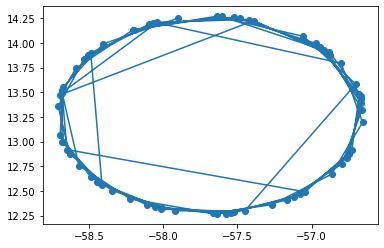

In [696]:
plt.plot(ncds.lon[0:72].isel(alt=10),
         ncds.lat[0:72].isel(alt=10),marker='o')

In [746]:
sondes_per_reg = 18
total_sondes = len(ncds.launch_time)

iterations = total_sondes - (sondes_per_reg - 1)

In [892]:
shape(grid[k])

(15, 15)

In [908]:
upto = 200 # height up to which the average is to be taken

grid_x = [None] * iterations
grid_y = [None] * iterations
grid = [None] * iterations

u = [None] * iterations
v = [None] * iterations
mean_time = [None] * iterations

for k in tqdm(range(0,iterations)) :
    
    lat_points = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
                    sel(alt=slice(0,upto)).lat.mean(dim='alt').values
    lon_points = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
                    sel(alt=slice(0,upto)).lon.mean(dim='alt').values + 360
    
    l_points = list(set(zip(lon_points,lat_points)))
    
    p_values = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
                    sel(alt=slice(0,upto)).pres.mean(dim='alt').values
    
    grid_x[k], grid_y[k] = np.mgrid[floor(np.min(lon_points)):ceil(np.max(lon_points)):0.2, 
                          floor(np.min(lat_points)):ceil(np.max(lat_points)):0.2]
    
    grid[k] = griddata(l_points,p_values, (grid_x[k],grid_y[k]), method = 'linear')
    
    u[k] = np.gradient(grid[k])[0]
    v[k] = np.gradient(grid[k])[1]
    
    f,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,6))
    
    norm = matplotlib.colors.Normalize(vmin=0.1,vmax=2,clip=False)
    cmap = matplotlib.colors.ListedColormap(plt.cm.cividis(np.linspace(0.25,1,10)), "name")
    
    vmin1 = 0.1; vmax1 = 0.5
    q = ax[0].quiver(grid_x[k],grid_y[k],
                     u[k],v[k],np.hypot(u[k],v[k]),
                     units='width', pivot='mid', width=0.01,#vmin=vmin1,vmax=vmax1,
               scale=1 / 0.1,cmap=cmap,norm=norm)
#     ax[0].quiverkey(q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')
                                                                                                                                                                                                                    
    cbar1 = plt.colorbar(q,ax=ax[0],norm=norm)
    cbar1.set_label('Pressure Gradient (hPa / $\degree$)')
#     cbar1 = q.clim(0.1,2)
    
    ax[0].scatter(lon_points,lat_points,s=45,c='r',label='Dropsonde considered')
    ax[0].legend(loc=1)
    ax[0].set_ylabel('Latitude ($\degree$N)')
    ax[0].set_xlabel('Longitude ($\degree$E)')
    
    vmin2=996; vmax2=1002.5
    levels2 = np.linspace(vmin2, vmax2+0.5,50)
    
#     CS = ax[1].contourf(grid_x[k],grid_y[k],
#                   grid[k],levels=levels2,vmin=vmin2,vmax=vmax2,cmap='Blues'
#                   )
    CS = ax[1].imshow(grid[k].T,interpolation='none',origin='lower',
                     extent=[floor(np.min(lon_points)),
                             ceil(np.max(lon_points)),
                             floor(np.min(lat_points)),
                             ceil(np.max(lat_points))],
                     vmin=vmin2,vmax=vmax2)
# plt.colorbar(orientation='horizontal')
    ax[1].set_xlabel('Longitude ($\degree$E)')
    cbar2 = plt.colorbar(CS,ax=ax[1],ticks=[vmin2,vmax2])
    cbar2.set_label('Pressure (hPa)')
    
    mean_time[k] = np.array(ncds.isel(launch_time=slice(k,
                    k+sondes_per_reg)).launch_time.mean().values, dtype='datetime64[m]')
    
    plt.suptitle(f'Mean time of circle: {mean_time[k]}',fontsize=16)
    plt.savefig(f'{k}.jpeg')
    plt.close()

/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [879]:
# upto = 200 # height up to which the average is to be taken

# grid_x = [None] * iterations
# grid_y = [None] * iterations
# # grid = [None] * iterations

# grid_u = [None] * iterations
# grid_v = [None] * iterations

# for k in tqdm(range(0,iterations)) :
    
#     lat_points = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
#                     sel(alt=slice(0,upto)).lat.mean(dim='alt').values
#     lon_points = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
#                     sel(alt=slice(0,upto)).lon.mean(dim='alt').values + 360
    
#     l_points = list(set(zip(lon_points,lat_points)))
    
#     u_values = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
#                     sel(alt=slice(0,upto)).u_wind.mean(dim='alt').values
#     v_values = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
#                     sel(alt=slice(0,upto)).v_wind.mean(dim='alt').values
    
#     grid_x[k], grid_y[k] = np.mgrid[floor(np.min(lon_points)):ceil(np.max(lon_points)):0.2, 
#                           floor(np.min(lat_points)):ceil(np.max(lat_points)):0.2]
    
#     grid_u[k] = griddata(l_points,u_values, (grid_x[k],grid_y[k]), method = 'linear')
#     grid_v[k] = griddata(l_points,v_values, (grid_x[k],grid_y[k]), method = 'linear')
    
# #     u[k] = np.gradient(grid[k])[0]
# #     v[k] = np.gradient(grid[k])[1]
    
#     f,ax = plt.subplots(1,1,sharex=True,sharey=True,figsize=(12,12))
    
#     norm = matplotlib.colors.Normalize(vmin=0.1,vmax=2,clip=False)
#     cmap = matplotlib.colors.ListedColormap(plt.cm.cividis(np.linspace(0.25,1,10)), "name")
    
#     vmin1 = 1; vmax1 = 10
#     q = ax.quiver(grid_x[k],grid_y[k],
#                      grid_u[k],grid_v[k],np.hypot(grid_u[k],grid_v[k]),
#                      units='width', pivot='mid', width=0.01,#vmin=vmin1,vmax=vmax1,
#                scale=1 / 0.1,cmap=cmap,norm=norm)
# #     ax[0].quiverkey(q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
# #                    coordinates='figure')
                                                                                                                                                                                                                    
#     cbar1 = plt.colorbar(q,ax=ax,norm=norm)
#     cbar1.set_label('Pressure Gradient (hPa / $\degree$)')
# #     cbar1 = q.clim(0.1,2)
    
# #     ax[0].scatter(lon_points,lat_points,s=45,c='r',label='Dropsonde considered')
# #     ax[0].legend()
# #     ax[0].set_ylabel('Latitude ($\degree$N)')
# #     ax[0].set_xlabel('Longitude ($\degree$E)')
    
# #     vmin2=996; vmax2=1002.5
# #     levels2 = np.linspace(vmin2, vmax2+0.5,50)
    
# #     CS = ax[1].contourf(grid_x[k],grid_y[k],
# #                   grid[k],levels=levels2,vmin=vmin2,vmax=vmax2,cmap='Blues'
# #                   )
# #     ax[1].set_xlabel('Longitude ($\degree$E)')
# #     cbar2 = plt.colorbar(CS,ax=ax[1],ticks=[vmin2,vmax2])
# #     cbar2.set_label('Pressure (hPa)')
    
#     mean_time = np.array(ncds.isel(launch_time=slice(k,
#                     k+sondes_per_reg)).launch_time.mean().values, dtype='datetime64[m]')
    
#     plt.suptitle(f'Mean time of circle: {mean_time}')
#     plt.savefig(f'{k}_uv.jpeg')
#     plt.close()

/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [1057]:
ncds.mr

<xarray.DataArray 'mr' (launch_time: 72, alt: 910)>
array([[        nan, 15.66802287, 15.64439262, ...,  0.11994295,
         0.11980946,  0.11965351],
       [        nan,         nan, 16.00423447, ...,  0.13602364,
         0.13536389,  0.13462967],
       [        nan,         nan, 17.31448655, ...,  0.17120948,
         0.17085143,  0.16999741],
       ...,
       [        nan,         nan,         nan, ...,  0.1446869 ,
         0.14374417,  0.14290245],
       [        nan, 15.38899337, 15.38866096, ...,  0.14186604,
         0.14155682,  0.14134638],
       [        nan,         nan,         nan, ...,  0.11136063,
         0.11133058,  0.1116944 ]])
Coordinates:
  * launch_time  (launch_time) datetime64[ns] 2020-01-24T09:50:07 ... 2020-01-24T16:45:06
  * alt          (alt) int64 0 10 20 30 40 50 ... 9040 9050 9060 9070 9080 9090
Attributes:
    long_name:  mixing ratio
    units:      gram/kg

In [1066]:
upto = 800 # height up to which the average is to be taken
fro = 600 # height from which the average is to be taken

grid_x = [None] * iterations
grid_y = [None] * iterations
grid = [None] * iterations

u = [None] * iterations
v = [None] * iterations

for k in tqdm(range(0,iterations)) :
    
    lat_points = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
                    sel(alt=slice(fro,upto)).lat.mean(dim='alt').values
    lon_points = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
                    sel(alt=slice(fro,upto)).lon.mean(dim='alt').values + 360
    
    l_points = list(set(zip(lon_points,lat_points)))
    
    mr_values = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
                    sel(alt=slice(fro,upto)).mr.mean(dim='alt').values
    
    grid_x[k], grid_y[k] = np.mgrid[floor(np.min(lon_points)):ceil(np.max(lon_points)):0.2, 
                          floor(np.min(lat_points)):ceil(np.max(lat_points)):0.2]
    
    grid[k] = griddata(l_points,mr_values, (grid_x[k],grid_y[k]), method = 'linear')
    
    u[k] = np.gradient(grid[k])[0]
    v[k] = np.gradient(grid[k])[1]
    
    f,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,6))
    
    vmin1 = 3e-01; vmax1 = 6e-01
    
    norm = matplotlib.colors.Normalize(vmin=vmin1,vmax=vmax1,clip=False)
    cmap = matplotlib.colors.ListedColormap(plt.cm.Blues(np.linspace(0.25,1,10)), "name")

    q = ax[0].quiver(grid_x[k],grid_y[k],
                     u[k],v[k],np.hypot(u[k],v[k]),
                     units='width', pivot='mid', width=0.01,#vmin=vmin1,vmax=vmax1,
                     cmap=cmap,norm=norm)
#     ax[0].quiverkey(q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')
                                                                                                                                                                                                                    
    cbar1 = plt.colorbar(q,ax=ax[0],norm=norm)
    cbar1.set_label('Moisture Gradient ( g/kg / $\degree$)')
#     cbar1 = q.clim(0.1,2)
    
    ax[0].scatter(lon_points,lat_points,s=45,c='r',label='Dropsondes considered')
    ax[0].legend(loc=1)
    ax[0].set_ylabel('Latitude ($\degree$N)')
    ax[0].set_xlabel('Longitude ($\degree$E)')
    
#     vmin2=0.015; vmax2=0.017
#     levels2 = np.linspace(vmin2, vmax2+0.5,50)
    
    vmin2=13; vmax2=15.5
    levels2 = np.linspace(vmin2, vmax2+0.5,50)
    
#     CS = ax[1].contourf(grid_x[k],grid_y[k],
#                   grid[k],levels=levels2,vmin=vmin2,vmax=vmax2,cmap='Blues'
#                   )
    CS = ax[1].imshow(grid[k].T,interpolation='none',origin='lower',
                     extent=[floor(np.min(lon_points)),
                             ceil(np.max(lon_points)),
                             floor(np.min(lat_points)),
                             ceil(np.max(lat_points))],
                     vmin=vmin2,vmax=vmax2)
# plt.colorbar(orientation='horizontal')
    ax[1].set_xlabel('Longitude ($\degree$E)')
    cbar2 = plt.colorbar(CS,ax=ax[1],ticks=[vmin2,vmax2])
    cbar2.set_label('Mixing Ratio (g/kg)')
    
    mean_time = np.array(ncds.isel(launch_time=slice(k,
                    k+sondes_per_reg)).launch_time.mean().values, dtype='datetime64[m]')
    
    plt.suptitle(f'Mean time of circle: {mean_time}')
    plt.savefig(f'{k}_mr_LCL.jpeg')
    plt.close()

/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [1062]:
grid[k]

array([[        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan,
        15.25018036, 14.96957623, 14.59742702, 14.19291805,         nan,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan, 15.22631455, 15.00787689,
        14.78943923, 14.57100157, 14.35256391, 14.13412625, 13.91568859,
                nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan, 12.88386743, 12.66542977,
        12.69828097, 12.93524137, 13.17220178, 

In [844]:
upto = 150 # height up to which the average is to be taken
fro = 0 # height from which the average is to be taken

grid_x = [None] * iterations
grid_y = [None] * iterations
grid = [None] * iterations

u = [None] * iterations
v = [None] * iterations

for k in tqdm(range(0,iterations)) :
    
    lat_points = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
                    sel(alt=slice(fro,upto)).lat.mean(dim='alt').values
    lon_points = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
                    sel(alt=slice(fro,upto)).lon.mean(dim='alt').values + 360
    
    l_points = list(set(zip(lon_points,lat_points)))
    
    q_values = ncds.isel(launch_time=slice(k,k+sondes_per_reg)).\
                    sel(alt=slice(fro,upto)).q.mean(dim='alt').values
    
    grid_x[k], grid_y[k] = np.mgrid[floor(np.min(lon_points)):ceil(np.max(lon_points)):0.2, 
                          floor(np.min(lat_points)):ceil(np.max(lat_points)):0.2]
    
    grid[k] = griddata(l_points,q_values, (grid_x[k],grid_y[k]), method = 'linear')
    
    u[k] = np.gradient(grid[k])[0]
    v[k] = np.gradient(grid[k])[1]
    
    f,ax = plt.subplots(1,2,sharex=True,sharey=True,figsize=(12,6))
    
    vmin1 = 0; vmax1 = 6e-04
    
    norm = matplotlib.colors.Normalize(vmin=vmin1,vmax=vmax1,clip=False)
    cmap = matplotlib.colors.ListedColormap(plt.cm.Blues(np.linspace(0.25,1,10)), "name")

    q = ax[0].quiver(grid_x[k],grid_y[k],
                     u[k],v[k],np.hypot(u[k],v[k]),
                     units='width', pivot='mid', width=0.01,#vmin=vmin1,vmax=vmax1,
                     cmap=cmap,norm=norm)
#     ax[0].quiverkey(q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')
                                                                                                                                                                                                                    
    cbar1 = plt.colorbar(q,ax=ax[0],norm=norm)
    cbar1.set_label('Moisture Gradient ( / $\degree$)')
#     cbar1 = q.clim(0.1,2)
    
    ax[0].scatter(lon_points,lat_points,s=45,c='r',label='Dropsondes considered')
    ax[0].legend()
    ax[0].set_ylabel('Latitude ($\degree$N)')
    ax[0].set_xlabel('Longitude ($\degree$E)')
    
#     vmin2=0.015; vmax2=0.017
#     levels2 = np.linspace(vmin2, vmax2+0.5,50)
    
    CS = ax[1].contourf(grid_x[k],grid_y[k],
                  grid[k],cmap='Blues'
                  ) #,levels=levels2,vmin=vmin2,vmax=vmax2
    ax[1].set_xlabel('Longitude ($\degree$E)')
    cbar2 = plt.colorbar(CS,ax=ax[1]) # ,ticks=[vmin2,vmax2]
    cbar2.set_label('Specific Humidity (hPa)') 
    
    mean_time = np.array(ncds.isel(launch_time=slice(k,
                    k+sondes_per_reg)).launch_time.mean().values, dtype='datetime64[m]')
    
    plt.suptitle(f'Mean time of circle: {mean_time}')
    plt.savefig(f'{k}_q_srf.jpeg')
    plt.close()

/Users/geet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()
